## Notebook to create raster masks from polygons
Needed for semantic segmentation of raster images. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import time, datetime
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Tmp fix:

In [17]:
df_tile_outlines = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == 'SK1357'].iloc[0]['geometry']
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')

In [105]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_detailed = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')


In [106]:
print(f'{eval_patch_outlines["SEL_ANNOT"].sum()} manually-selected patches of {len(eval_patch_outlines)} patches have been annotated')
print(f'{eval_patch_outlines["RAND_ANNOT"].sum()} randomly-selected of {len(eval_patch_outlines)} patches have been annotated')


10 manually-selected patches of 11250 patches have been annotated
450 randomly-selected of 11250 patches have been annotated


In [107]:
df_detailed = lca.test_validity_geometry_column(df_detailed)


Geometry Ring Self-intersection[407383.997302149 405117.495042628] for inds [1737]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1740]
Attempting to make valid
Done
Geometry Ring Self-intersection[407643.878683077 352269.720591962] for inds [480]
Attempting to make valid
Done
Geometry Ring Self-intersection[414319.998781238 400124.960028019] for inds [1798]
Attempting to make valid
Done
Geometry Ring Self-intersection[414767.998541906 400865.088008983] for inds [1810]
Attempting to make valid
Done


In [108]:
df_detailed = df_detailed[df_detailed['Class_low'] != '0']

In [109]:
area_arr = np.argsort(df_detailed['geometry'].area.values)
# area_arr[:10]
df_detailed.iloc[area_arr[:10]]

,Class_low,source,geometry
1804,D2d,None,"POLYGON ((414338.023 400107.402, 414337.817 40..."
1738,F3d,None,"POLYGON ((407452.773 405515.503, 407453.091 40..."
1386,E2a,None,"POLYGON ((406191.997 382359.997, 406193.137 38..."
411,H3b,OS NGD retrieved 2023-01-10,"POLYGON ((407989.649 352000.000, 407987.258 35..."
658,E2b,Manual annotation DA SG 2023,"POLYGON ((413380.340 357763.090, 413369.410 35..."
1021,F2,OS NGD retrieved 2023-01-10,"POLYGON ((418243.126 371559.372, 418245.868 37..."
409,H1b,OS NGD retrieved 2023-01-10,"POLYGON ((406999.999 352721.570, 406999.999 35..."
884,C2,NFI 2020 retrieved 2023-02-15,"POLYGON ((415967.903 388666.310, 415966.000 38..."
1199,E2a,Manual annotation DA SG 2023,"POLYGON ((420554.360 355535.110, 420553.530 35..."
1191,C1,Manual annotation DA SG 2023,"POLYGON ((420415.844 355327.139, 420424.999 35..."


In [110]:
eval_patch_outlines

,RAND_ANNOT,SEL_ANNOT,Class_low,tile_i,tile_patch,patch_i,geometry
0,1,0,0,SE0503,SE0503_p0,0,"POLYGON ((405064.003 403999.995, 405064.003 40..."
1,0,0,0,SE0503,SE0503_p15,15,"POLYGON ((405064.003 403935.995, 405064.003 40..."
2,0,0,0,SE0503,SE0503_p30,30,"POLYGON ((405064.003 403871.995, 405064.003 40..."
3,0,0,0,SE0503,SE0503_p45,45,"POLYGON ((405064.003 403807.995, 405064.003 40..."
4,0,0,0,SE0503,SE0503_p60,60,"POLYGON ((405064.003 403743.995, 405064.003 40..."
...,...,...,...,...,...,...,...
11245,0,0,0,SK2777,SK2777_p164,164,"POLYGON ((427960.003 377359.998, 427960.003 37..."
11246,1,0,0,SK2777,SK2777_p179,179,"POLYGON ((427960.003 377295.998, 427960.003 37..."
11247,0,0,0,SK2777,SK2777_p194,194,"POLYGON ((427960.003 377231.998, 427960.003 37..."
11248,0,0,0,SK2777,SK2777_p209,209,"POLYGON ((427960.003 377167.998, 427960.003 37..."


In [112]:
dict_pols_detailed_rand = lca.get_pols_for_tiles(df_pols=df_detailed, col_name='tile_patch',
                        df_tiles=eval_patch_outlines[np.logical_or(eval_patch_outlines['RAND_ANNOT'] == 1, eval_patch_outlines['SEL_ANNOT'] == 1)], 
                        col_ind_name='Class_low', col_class_name='Class_low')

100%|██████████| 460/460 [00:01<00:00, 253.89it/s]

6 tiles were empty: ['SE0705_p64', 'SE0705_p65', 'SE0800_p53', 'SE1203_p184', 'SK0366_p141', 'SK1992_p90']


In [113]:
dict_area_0 = {}
for tp, df in dict_pols_detailed_rand.items():
    # print(f'{tp}: {len(df)}')
    if '0' in df['Class_low'].values:
        dict_area_0[tp] = df[df['Class_low'] == '0']['geometry'].area.sum()
    else:
        dict_area_0[tp] = 0

# plt.hist(dict_area_0.values(), bins=100);
np.sum(np.array(list(dict_area_0.values())) > 1)

57

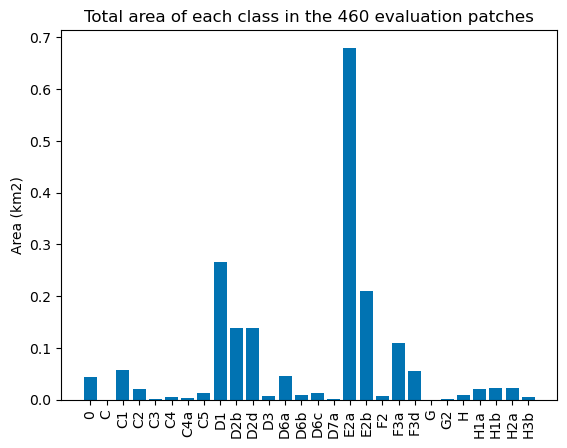

In [114]:
df_patches_only_concat = pd.concat(list(dict_pols_detailed_rand.values()))
unique_classes = df_patches_only_concat['Class_low'].unique()
dict_total_area = {}
unique_classes = np.sort(unique_classes)
for c in unique_classes:
    dict_total_area[c] = df_patches_only_concat[df_patches_only_concat['Class_low'] == c]['geometry'].area.sum()
    dict_total_area[c] = dict_total_area[c] / 1e6  # convert to km2

## Bar plot of total area of each class
ax = plt.subplot(111)
ax.bar(dict_total_area.keys(), dict_total_area.values())
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);
plt.xticks(rotation=90);
ax.set_ylabel('Area (km2)')
ax.set_title(f'Total area of each class in the {len(dict_pols_detailed_rand)} evaluation patches');


In [8]:
pd_outline = lca.load_pols(path_dict['pd_outline'])
os_grid = lca.load_pols(path_dict['landscape_character_grid_path'])
# path_dict.keys()

In [9]:
len(os_grid)

2125

In [10]:
## Find all os grid polygons that intersect with pd_outline 
os_grid = os_grid[os_grid.intersects(pd_outline.iloc[0]['geometry'])]
print(len(os_grid))

1617


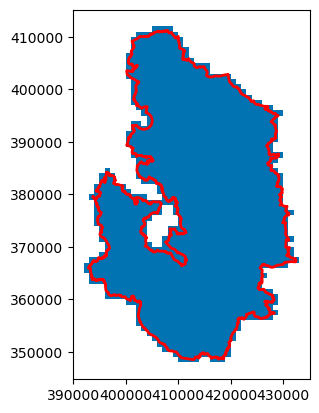

In [11]:
ax = plt.subplot(111)


os_grid.plot(ax=ax)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

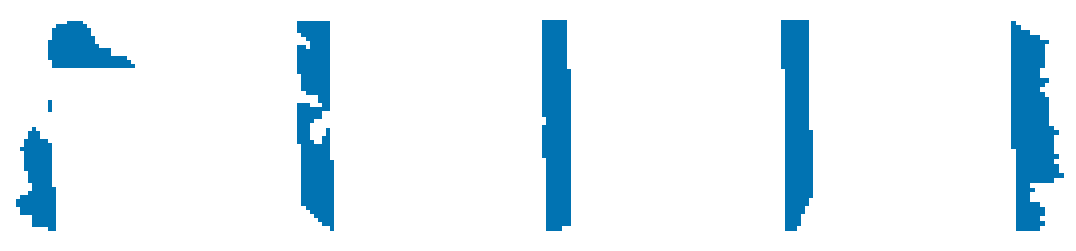

In [18]:
# 330 * 5
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for ii in range(5):
    dir_name = f'../content/os_grid_pd/all_tiles_part_{ii}'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    df_sub = os_grid.iloc[ii*330:(ii+1)*330]
    df_sub.to_file(f'{dir_name}/all_tiles_part{ii}.shp')
    df_sub.plot(ax=ax[ii])
    ax[ii].axis('off')

### Example tile:

(3, 8000, 8000) <class 'numpy.ndarray'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


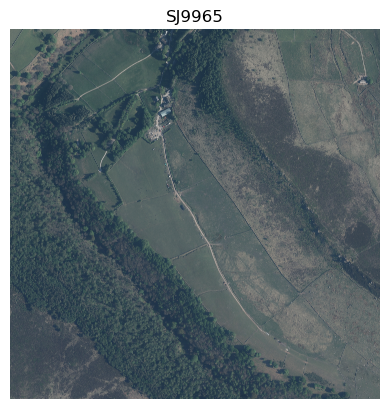

In [10]:
## Load image:

example_tiff_file = 'SJ9965.tif'
# example_tiff_file = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SE0800_lc_2022_mask.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)
# example_tiff_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SK2196_lc_2022_mask.tif'
ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

# tmp = lcv.plot_image_as_patches(im=ex_tile, name_file=example_tiff_file)

### Automatically intersect LC polygons with tiles; and create rasterized patches:

In [4]:
## Load landcover polygons:

df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
# df_lc_80s = lca.load_pols(pol_path='/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022.shp')
df_lc_80s = lca.test_validity_geometry_column(df=df_lc_80s)
df_lc_80s = lca.add_main_category_column(df_lc=df_lc_80s) 
df_lc_80s

,AREA,PERIMETER,LC_N_80,LC_D_80,MI_PRINX,geometry,Class_Code
0,2.288935e+05,1931.281171,19,Improved Pasture,1,"POLYGON ((407724.666 411168.713, 407854.641 41...",E
1,8.103939e+05,6180.868624,12,Upland Heath/Grass Mosaic,2,"POLYGON ((407267.642 410992.244, 407326.372 41...",D
2,3.024182e+06,30493.715242,7,Upland Grass Moor,3,"POLYGON ((405616.816 409724.857, 405615.571 40...",D
3,3.141201e+06,17829.297205,8,Blanket Peat Grass Moor,4,"POLYGON ((406402.661 410926.453, 406419.695 41...",D
4,5.524007e+03,360.239964,20,Rough Pasture,5,"POLYGON ((405569.382 410874.398, 405584.644 41...",E
...,...,...,...,...,...,...,...
8477,2.946860e+03,210.674150,19,Improved Pasture,8478,"POLYGON ((416356.527 348866.777, 416357.591 34...",E
8478,1.588031e+03,186.955561,1,Broadleaved High Forest,8479,"POLYGON ((412660.720 348649.559, 412658.280 34...",C
8479,6.253066e+03,340.410463,36,Isolated Farmsteads (>0.25 ha),8480,"POLYGON ((412871.439 348609.371, 412858.033 34...",H
8480,1.770921e+05,2285.262979,2,Coniferous High Forest,8481,"POLYGON ((411786.076 405491.149, 411803.349 40...",C


In [10]:
# df_lc_80s = df_lc_80s.drop('AREA', axis=1)
# df_lc_80s['area'] = df_lc_80s['geometry'].area

df_h = df_lc_80s[df_lc_80s['Class_Code'] == 'H']
area_h = df_h['area'].sum()
total_area = df_lc_80s['area'].sum()

print('Total area: ', total_area / 1e4)
print('Area H: ', area_h / 1e4)
print('Percentage H: ', area_h/total_area)



Total area:  143835.0136998267
Area H:  2935.024649254558
Percentage H:  0.02040549497481707


In [ ]:
# ## Get intersection of polygons with tiles
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir('/home/tplas//data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/tiles/'), verbose=1)  # get df of square polygons of tiles 
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# dict_intersect_pols = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles)

In [8]:
## Load shp files of tiles and intersect with PD LC:

df_tiles_sample = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp')
# df_tiles_sample = lca.load_pols('/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/3_urban_tiles/3_urban_tiles.shp')
dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=False)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)


100%|██████████| 11/11 [00:00<00:00, 49.98it/s]


In [5]:
# lca.add_main_category_index_column(dict_intersect_pols_tiles_sample['SE1301'])
dict_intersect_pols_tiles_sample['SE1301']

,geometry,LC_N_80,LC_D_80
0,"MULTIPOLYGON (((412999.996 401267.618, 413037....",7,Upland Grass Moor
1,"POLYGON ((413781.665 401999.998, 413797.467 40...",8,Blanket Peat Grass Moor
2,"POLYGON ((413999.998 401892.099, 413961.692 40...",6,Upland Heath


In [10]:
## Convert all polygons labels to raster and save:

dict_shp = dict_intersect_pols_tiles_sample
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/'
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/tiles/117637_20221207/tile_masks/'
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/'
save_mask_dir = '/home/tplas/data/gis/tmp_trial/original/'
for key_tile, df_tile in tqdm(dict_shp.items()):
    # dict_shp[key_tile] = lca.add_main_category_index_column(df_tile)
    ex_raster = lca.convert_shp_mask_to_raster(df_shp=df_tile, filename=key_tile + '_lc_80s_mask', 
                                maskdir=save_mask_dir, 
                                # col_name='class_ind',
                                col_name='LC_N_80',
                                # ex_tile=ex_raster,
                                # resolution=(-0.125, 0.125),
                                plot_raster=False, # whether to plot
                                save_raster=True, # whether to store on disk
                                verbose=0)
    # assert ex_raster['class_ind'].shape == (8000, 8000), key_tile
    assert ex_raster['LC_N_80'].shape == (8000, 8000), key_tile


100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


### Some plots of class distributions:

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


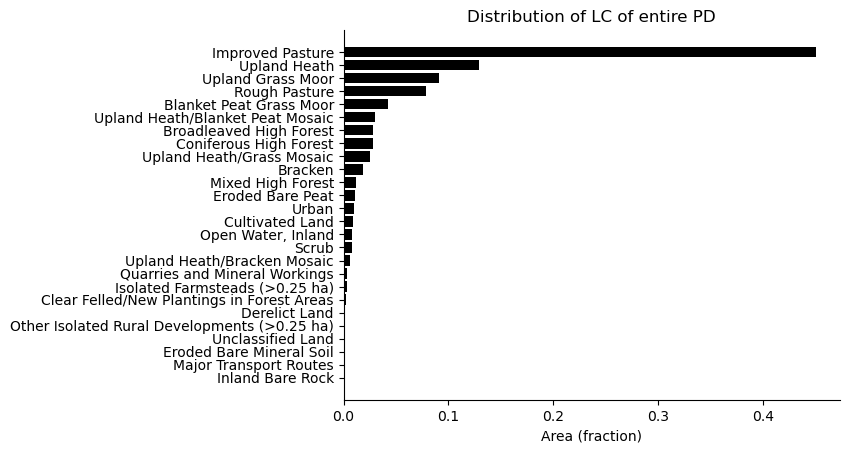

In [5]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

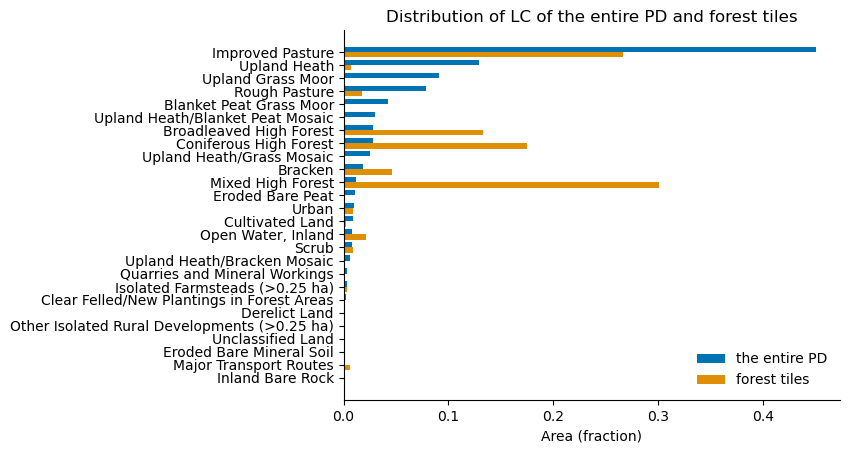

In [7]:
ax_distr, _ = lcv.plot_distr_classes_from_multiple_shapes(dict_dfs_lc={'the entire PD': df_lc_80s, 'forest tiles': df_tiles_few_changes_lc})

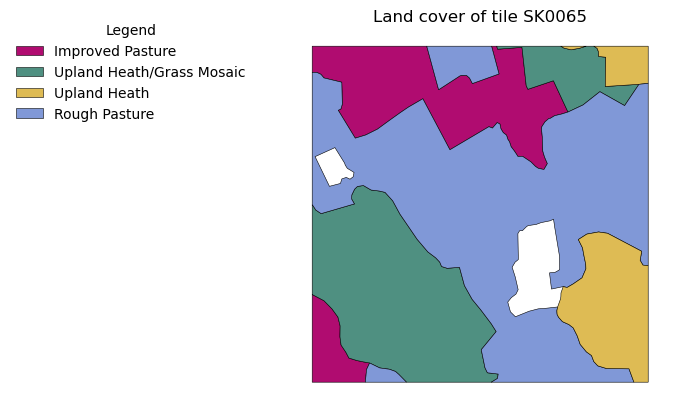

In [8]:
_ = lcv.plot_lc_from_gdf_dict(df_pols_tiles=dict_intersect_pols, tile_name="SK0065")

Current data size cube is 512.128008 MB
New cube data size is 64.128008 MB


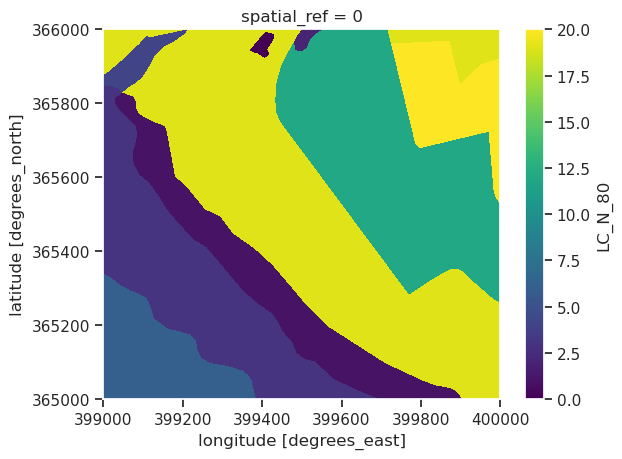

In [137]:
## Example: convert polygons labels to raster:
dict_shp = dict_intersect_pols
key_tile = "SJ9965"

ex_raster = lca.convert_shp_mask_to_raster(df_shp=dict_shp[key_tile], filename=key_tile + '_lc_80s_mask', 
                                plot_raster=True, # whether to plot
                                save_raster=False, # whether to store on disk
                                verbose=1)

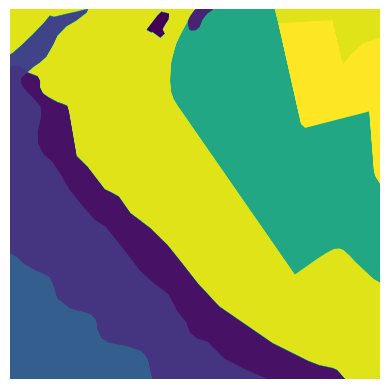

In [11]:
## Load saved raster mask
ex_mask_tif = lca.load_tiff(tiff_file_path=os.path.join(path_dict['mask_path'], 'SJ9965' + '_lc_80s_mask.tif'))
lcv.plot_image_simple(im=ex_mask_tif)

## Create Patches and save:

In [11]:
# list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
# list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/')list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/')
list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/tmp_trial/original/')

print(f'Found {len(list_tiff_files)} images and {len(list_mask_files)} masks')
print(list_tiff_files[:4])

Found 11 images and 11 masks
['/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0560.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0796.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2669.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2567.tif']


## Continue:

In [12]:
# dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/images/'
# dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/masks/'
dir_im_patches = '/home/tplas/data/gis/tmp_trial/original/images/'
dir_mask_patches = '/home/tplas/data/gis/tmp_trial/original/masks/'

lca.create_and_save_patches_from_tiffs(list_tiff_files=list_tiff_files, list_mask_files=list_mask_files,
                                       dir_im_patches=dir_im_patches, dir_mask_patches=dir_mask_patches,
                                       mask_fn_suffix='_lc_80s_mask.tif',
                                       save_files=True)

## Notebook to create label mapping transformations
- Map old labels to new labels
- Old labels: 1980s classification scheme
- Multiple new label schemes possible.


In [3]:
# save_folder = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/'
dict_mapping = lca.create_empty_label_mapping_dict()

In [5]:
tmp = lca.create_new_label_mapping_dict(save_mapping=True, mapping_type='E_subclasses_only')

### Create table with key for LC schema:
 - Old 80s schema
 - New 2022 schema 
 - Mapping betweens those 
 - Code + name + index

In [56]:
df_schema = lca.create_df_mapping_labels_2022_to_80s()

adding scrub
adding wetland
adding transport


In [57]:
df_schema

,description_2022,description_80s,code_80s,code_2022,index_2022,index_80s
0,NO CLASS,NO CLASS,0,0,0,0
1,Broadleaved High Forest,Broadleaved High Forest,C1,C1,1,1
2,Coniferous High Forest,Coniferous High Forest,C2,C2,2,2
3,Mixed High Forest,Mixed High Forest,C3,C3,3,3
4,Scrub,Scrub,C4,C4a,4,4
5,Scrub Pasture,Scrub,C4,C4b,5,4
6,Woodland/Scrub Edge,Scrub,C4,C4c,6,4
7,Clear Felled/New Plantings in Forest Areas,Clear Felled/New Plantings in Forest Areas,C5,C5,7,5
8,Upland Heath,Upland Heath,D1,D1,8,6
9,Upland Grass Moor,Upland Grass Moor,D2b,D2b,9,7


## Create new selection of tiles for NTM data:

In [20]:
df_tiles_train = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp')
df_tiles_eval = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
df_tiles_concat = pd.concat([df_tiles_train, df_tiles_eval], axis=0)
df_tiles_concat = df_tiles_concat.reset_index(drop=True)

list_tiles_eval_exclude = ['SE0503', 'SE0705', 'SE0800', 'SE1203', 'SE1400', 'SK0684', 
                           'SK0686', 'SK0790', 'SK0896', 'SK0988', 'SK1399', 'SK1798', 
                           'SK1896', 'SK1992', 'SK1998', 'SK2091', 'SK2096', 'SK2196', 
                           'SK2777',   # up until here: eval without trees
                           'SK0752', 'SK0961', 'SJ9566', 'SK1588', 'SK1360',  # this row; eval already in NTM
                           'SE1301', 'SK0792', 'SK0796', 'SK1095', 'SK1295', 'SK2969']  # this row: training tiles without trees 

In [21]:
df_tiles_ntm = df_tiles_concat[np.logical_not(df_tiles_concat['PLAN_NO'].isin(list_tiles_eval_exclude))]
assert len(df_tiles_ntm) == 31

In [23]:
df_tiles_ntm.to_file('/home/tplas/repos/cnn-land-cover/content/tree_tiles/tiles_ntm_data/tiles_ntm_data.shp')

## Add NFI data to tile outlines.. v2

In [134]:
df_tiles_outline = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
print(f'Loaded {len(df_tiles_outline)} tiles.')

## Load NFI data:
df_nfi = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/NFI_data/NFI_pd_incl_ambiguous.shp')
print(f'Loaded {len(df_nfi)} NFI polygons.')
nfi_class_col = 'Class_low'
df_nfi = df_nfi.drop(columns=[col_name for col_name in df_nfi.columns if col_name not in ['Class_low', 'geometry']])
df_nfi['source'] = 'NFI 2020 retrieved 2023-02-15' 

## Load main-class annotated + FGH layer:
df_fgh_main = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
print(f'Loaded {len(df_fgh_main)} FGH polygons.')
filepath_manual_fgh_layer = '/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp'
date_fgh_modified = str(datetime.datetime.strptime(time.ctime(os.path.getmtime(filepath_manual_fgh_layer)), '%a %b %d %H:%M:%S %Y').date())
source_fgh = f'OS NGD retrieved {date_fgh_modified}'

## Remove all tiny FGH polygons:
list_inds_remove = [] 
list_inds_keep = []
for ii in range(len(df_fgh_main)):
    label = df_fgh_main['Class_low'][ii].upper()
    if len(label)  == 1:
        if label in ['C', 'D', 'E']:
            list_inds_remove.append(ii)
        elif label in ['F', 'G', 'H']:
            if df_fgh_main.iloc[ii]['geometry'].area < 100:
                list_inds_remove.append(ii)
            else:
                list_inds_keep.append(ii) 
        else:
            raise ValueError('Unknown label.')
    else:
        list_inds_keep.append(ii)

assert len(list_inds_remove) + len(list_inds_keep) == len(df_fgh_main) 
df_fgh_main = df_fgh_main.iloc[np.array(list_inds_keep)]
df_fgh_main = df_fgh_main.reset_index(drop=True)
df_fgh_main = df_fgh_main.drop(columns=['Class_high'])

## Add sources:
list_sources = []
for ii in range(len(df_fgh_main)):
    label = df_fgh_main['Class_low'][ii].upper()
    if len(label)  == 1:
        if label in ['C', 'D', 'E']:
            raise ValueError('Still some CDE labels.')
        elif label in ['F', 'G', 'H']:
            list_sources.append('Manual annotation DA SG 2023')
        else:
            raise ValueError('Unknown label.')
    else:
        if label[0] in ['C', 'D', 'E']:
            list_sources.append('Manual annotation DA SG 2023')
        elif label[0] in ['F', 'G', 'H']:
            list_sources.append(source_fgh)
        else:
            raise ValueError(f'Unknown label {label}.')

assert len(list_sources) == len(df_fgh_main)
df_fgh_main['source'] = list_sources
assert (set(df_nfi.columns) == set(df_fgh_main.columns)), f'Columns of NFI and FGH dataframes are not the same: {df_nfi.columns} vs {df_fgh.columns}'

df_fgh_main = lca.test_validity_geometry_column(df_fgh_main)
df_nfi = lca.test_validity_geometry_column(df_nfi)

Loaded 50 tiles.
Loaded 2935 NFI polygons.
Loaded 1807 FGH polygons.
Geometry Ring Self-intersection[407643.878683077 352269.720591962] for inds [984]
Attempting to make valid
Done
Geometry Ring Self-intersection[396662.087 372036.395] for inds [2088]
Attempting to make valid
Done


In [214]:
df_merged_manual_layers = pd.concat([df_nfi, df_fgh_main], axis=0)
df_merged_manual_layers = df_merged_manual_layers.reset_index(drop=True)
dict_merged = lca.get_pols_for_tiles(df_pols=df_merged_manual_layers, df_tiles=df_tiles_outline, 
                            col_name='PLAN_NO', 
                            col_ind_name='Class_low', col_class_name='source', verbose=0)


100%|██████████| 50/50 [00:00<00:00, 56.24it/s]


In [215]:
list_manual_annotated_tiles = ['SK0752', 'SK0852', 'SK1357', 'SK2055']
for tilename in list_manual_annotated_tiles:
    ## Get rid of 0 because it's just tiny stripes
    dict_merged[tilename] = dict_merged[tilename][dict_merged[tilename]['Class_low'] != '0']

for tilename, gdf in dict_merged.items():
    # print(f'{tilename}: {len(gdf)}')
    
    dict_merged[tilename] = gdf.explode(index_parts=True).reset_index(drop=True)
    # assert that all goemetry re Polygon
    for ii in range(len(dict_merged[tilename])):
        assert dict_merged[tilename]['geometry'][ii].geom_type == 'Polygon', f'Found a non-Polygon geometry in {tilename}'



In [217]:
## removing overlap between NFi and FGH
for tilename, gdf in dict_merged.items():  # using new loop to make sure exploding is ok 
    ## see if polygons with NFI source intersect with any other polygons:
    inds_nfi = np.where(gdf['source'] == 'NFI 2020 retrieved 2023-02-15')[0]

    if len(inds_nfi) > 0:
        
        gdf_fgh = gdf[gdf['source'] == source_fgh] 
        if len(gdf_fgh) == 0:
            continue
        merged_pol_non_nfi = gdf_fgh['geometry'].unary_union
        list_new_pols = []
        for ind in inds_nfi:
            pol_orig = gdf.iloc[ind]['geometry']
            pol_diff = pol_orig.difference(merged_pol_non_nfi)
            if pol_diff != pol_orig:  # overlap 
                list_new_pols.append(pol_diff)
            else:
                list_new_pols.append(pol_orig)

        assert len(gdf.iloc[inds_nfi]) == len(list_new_pols)
        # if len(list_new_pols) == 1:
        list_new_pols = gpd.GeoSeries(list_new_pols)
        # break
        gdf.loc[inds_nfi, 'geometry'] = list_new_pols
        gdf = lca.test_validity_geometry_column(gdf)
        gdf = gdf.explode(index_parts=True).reset_index(drop=True)
        gdf = lca.test_validity_geometry_column(gdf)
        dict_merged[tilename] = gdf 
        

In [227]:
df_merged = pd.concat(list(dict_merged.values())).reset_index(drop=True)
df_merged = df_merged[df_merged['geometry'].area > 1]
df_merged = df_merged.reset_index(drop=True)
df_merged = lca.test_validity_geometry_column(df_merged) 
df_merged.to_file('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_merged

,Class_low,source,geometry
0,0,0,"POLYGON ((405000.003 403000.002, 405000.003 40..."
1,0,0,"POLYGON ((406999.999 404999.999, 406999.999 40..."
2,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((408741.500 400245.000, 408753.000 40..."
3,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408320.500 400187.500, 408319.500 40..."
4,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408384.500 400253.000, 408382.000 40..."
...,...,...,...
1358,F2,OS NGD retrieved 2023-01-10,"POLYGON ((427935.150 377017.270, 427933.890 37..."
1359,F2,OS NGD retrieved 2023-01-10,"POLYGON ((427973.790 377059.340, 427960.350 37..."
1360,H1b,OS NGD retrieved 2023-01-10,"POLYGON ((427948.110 377928.370, 427949.420 37..."
1361,0,0,"POLYGON ((427000.003 377000.004, 427000.003 37..."


In [16]:
# gdf.plot(column='source', figsize=(15, 15))
# plt.axis('off')

## Create tile outlines + override layers for manual annotation
- Get list of tiles
- Get tile outlines 
- Override with NFI (some detailed, some not) + add source 
- Override with NGD (detailed) + add source 

In [11]:
df_tiles_outline = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
print(f'Loaded {len(df_tiles_outline)} tiles.')

## Load FGH data:
filepath_manual_fgh_layer = '/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp'
df_fgh = lca.load_pols(filepath_manual_fgh_layer)
date_fgh_modified = str(datetime.datetime.strptime(time.ctime(os.path.getmtime(filepath_manual_fgh_layer)), '%a %b %d %H:%M:%S %Y').date())
   
print(f'Loaded {len(df_fgh)} FGH polygons.')
## Replace lc_label column by Class_low column:
df_fgh['Class_low'] = df_fgh['lc_label']
df_fgh = df_fgh.drop(columns=['lc_label'])
df_fgh['source'] = f'OS NGD retrieved {date_fgh_modified}'

## Load NFI data:
df_nfi = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/NFI_data/NFI_pd_incl_ambiguous.shp')
print(f'Loaded {len(df_nfi)} NFI polygons.')
nfi_class_col = 'Class_low'
df_nfi = df_nfi.drop(columns=[col_name for col_name in df_nfi.columns if col_name not in ['Class_low', 'geometry']])
df_nfi['source'] = 'NFI 2020 retrieved 2023-02-15' 



Loaded 50 tiles.
Loaded 18056 FGH polygons.
Loaded 2935 NFI polygons.


In [12]:
# ## Merge NFI and FGH layers into one df. Resolve overlaps by giving priority to FGH layer:

# df_diff = gpd.overlay(df_nfi, df_fgh, how='difference')  # Get df pred polygons that are not in df fgh 
# df_diff = df_diff.explode().reset_index(drop=True)
# df_intersect = gpd.overlay(df_nfi, df_fgh, how='intersection')  # Get overlap between df pred and df fgh
# df_intersect['Class_low'] = df_intersect['Class_low_2']  #  FGH layer has priority (and was 2nd arg in overlay() above)
# df_intersect['source'] = df_intersect['source_2']
# df_intersect = df_intersect.drop(['Class_low_1', 'Class_low_2'], axis=1)
# df_intersect = df_intersect.drop(['source_1', 'source_2'], axis=1)
# df_intersect = df_intersect.explode().reset_index(drop=True)  # in case multiple polygons are created by intersection
# df_merged_manual_layers = gpd.GeoDataFrame(pd.concat([df_diff, df_intersect], ignore_index=True))  # Concatenate all polygons


In [13]:
# dict_nfi, df_nfi_in_tiles = lca.get_pols_for_tiles_simple(df_pols=df_nfi, df_tiles=df_tiles_outline)
# dict_fgh, df_fgh_in_tiles = lca.get_pols_for_tiles_simple(df_pols=df_fgh, df_tiles=df_tiles_outline)

df_merged_manual_layers = pd.concat([df_nfi, df_fgh], axis=0)
df_merged_manual_layers = df_merged_manual_layers.reset_index(drop=True)
dict_merged = lca.get_pols_for_tiles(df_pols=df_merged_manual_layers, df_tiles=df_tiles_outline, col_name='PLAN_NO', 
                            col_ind_name='Class_low', col_class_name='source', verbose=0)
assert (set(df_nfi.columns) == set(df_fgh.columns)), f'Columns of NFI and FGH dataframes are not the same: {df_nfi.columns} vs {df_fgh.columns}'

## Create dict for each tile with merged nfi and fgh data:
# dict_merged = {} 
# for tilename, df_nfi_tile in tqdm(dict_nfi.items()):
#     df_fgh_tile = dict_fgh[tilename]
#     df_merged = pd.concat([df_nfi_tile, df_fgh_tile], axis=0)
#     df_merged = df_merged.reset_index(drop=True)
#     dict_merged[tilename] = df_merged

100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


In [ ]:
## check if any polygons overlap with others in dict_nfi['SK0852'] : 
# tmp = dict_nfi['SK0852'].copy()

for tilename, df_tile in tqdm(dict_merged.items()):
    tmp = df_tile.copy()
    list_conflicts = []
    for ii in range(len(tmp)):
        for jj in range(ii, len(tmp)):
            if ii != jj and tmp.iloc[ii]['geometry'].intersection(tmp.iloc[jj]['geometry']).area > 0:
                assert tmp.iloc[ii]["source"] != tmp.iloc[jj]["source"]
                list_conflicts.append((ii, jj))
                print(ii, jj) 
                print(f'Class_low of both: {tmp.iloc[ii]["Class_low"]}, {tmp.iloc[jj]["Class_low"]}')
                # print(f'Source of both: {tmp.iloc[ii]["source"]}, {tmp.iloc[jj]["source"]}')
                # print(f'Area of overlap and difference: {tmp.iloc[ii]["geometry"].intersection(tmp.iloc[jj]["geometry"]).area}, {tmp.iloc[ii]["geometry"].difference(tmp.iloc[jj]["geometry"]).area}')

    source_replace = 'NFI 2020 retrieved 2023-02-15'
    ## go through conflicts are replace source_replace with other source:
    for ii, jj in list_conflicts:
        source_ii = tmp.iloc[ii]["source"]
        source_jj = tmp.iloc[jj]["source"]
        if source_ii == source_replace:
            replace_ind = ii 
            other_ind = jj
            source_other = source_jj
        else:
            replace_ind = jj
            other_ind = ii
            source_other = source_ii
        
        area_intersection = tmp.iloc[replace_ind]['geometry'].intersection(tmp.iloc[other_ind]['geometry'])
        area_difference = tmp.iloc[replace_ind]['geometry'].difference(tmp.iloc[other_ind]['geometry'])

        # tmp.loc[[replace_ind], 'geometry'] = gpd.GeoSeries([area_difference]) # replace geometry of replace_ind with difference 
        ## add new row with intersection geometry and other source:
        tmp = tmp.append({'geometry': area_intersection, 'Class_low': tmp.iloc[other_ind]['Class_low'],
                        'source': source_other}, ignore_index=True)
        tmp = tmp.append({'geometry': area_difference, 'Class_low': tmp.iloc[replace_ind]['Class_low'],
                        'source': source_replace}, ignore_index=True)
        tmp = tmp.drop([replace_ind], axis=0)
        print(f'area intersection: {area_intersection}, area difference: {area_difference}')
    dict_merged[tilename] = tmp.copy() # update dict_nfi with new polygons

In [140]:
dict_merged['SK0852'].explode().reset_index(drop=True)

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


,Class_low,source,geometry
0,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((408579.874 352047.026, 408585.136 35..."
1,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((408430.940 352087.960, 408418.610 35..."
2,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408668.800 352015.770, 408663.920 35..."
3,H1a,OS NGD retrieved 2023-01-10,"POLYGON ((408000.001 352037.310, 408001.090 35..."
4,H1a,OS NGD retrieved 2023-01-10,"POLYGON ((408096.660 352004.740, 408085.380 35..."
5,H1a,OS NGD retrieved 2023-01-10,"POLYGON ((408166.800 352997.600, 408166.850 35..."
6,H1a,OS NGD retrieved 2023-01-10,"POLYGON ((408996.830 352869.330, 408993.002 35..."
7,H1a,OS NGD retrieved 2023-01-10,"POLYGON ((409000.004 352879.270, 408999.702 35..."
8,H3b,OS NGD retrieved 2023-01-10,"POLYGON ((408076.879 352000.000, 408073.560 35..."
9,H3b,OS NGD retrieved 2023-01-10,"POLYGON ((408095.770 352042.170, 408095.360 35..."


In [15]:
df_merged = pd.concat(list(dict_merged.values())).reset_index(drop=True)
df_merged

,geometry,Class_low,source
0,"POLYGON ((405000.003 403000.002, 405000.003 40...",0,0
1,"POLYGON ((406999.999 404999.999, 406999.999 40...",0,0
2,"POLYGON ((408741.500 400245.000, 408753.000 40...",C,NFI 2020 retrieved 2023-02-15
3,"POLYGON ((408321.500 400204.000, 408322.500 40...",G2,OS NGD retrieved 2023-01-10
4,"POLYGON ((408391.500 400270.500, 408390.500 40...",G2,OS NGD retrieved 2023-01-10
...,...,...,...
662,"POLYGON ((427774.626 377000.004, 427776.600 37...",F2,OS NGD retrieved 2023-01-10
663,"POLYGON ((427935.150 377026.040, 427935.360 37...",F2,OS NGD retrieved 2023-01-10
664,"POLYGON ((427999.997 377046.929, 427998.160 37...",F2,OS NGD retrieved 2023-01-10
665,"POLYGON ((427881.412 377999.998, 427882.060 37...",H1b,OS NGD retrieved 2023-01-10


In [16]:
df_merged = lca.test_validity_geometry_column(df_merged) 

In [20]:
df_merged.to_file('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_detailed/landscape_character_2022_detailed.shp')

In [ ]:
df_test = df_nfi

for ii in range(len(df_test)):
    for jj in range(ii, len(df_test)):
        if ii != jj and df_test.iloc[ii]['geometry'].intersection(df_test.iloc[jj]['geometry']).area > 1e-1:
            assert False, f'Polygons {ii} and {jj} still overlap with area {df_test.iloc[ii]["geometry"].intersection(df_test.iloc[jj]["geometry"]).area}'

In [ ]:
# dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
#                                                           extract_main_categories_only=False)
# df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)

dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_nfi, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=False)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)